<a href="https://colab.research.google.com/github/planet-c-am/Heatmap/blob/main/heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-2829895938.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018['Quarter'] = df_2018['Order Date'].dt.to_period('Q').astype(str)
/tmp/ipython-input-2829895938.py:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_table = table_feature.applymap(lambda x: f'${x:,.0f}')


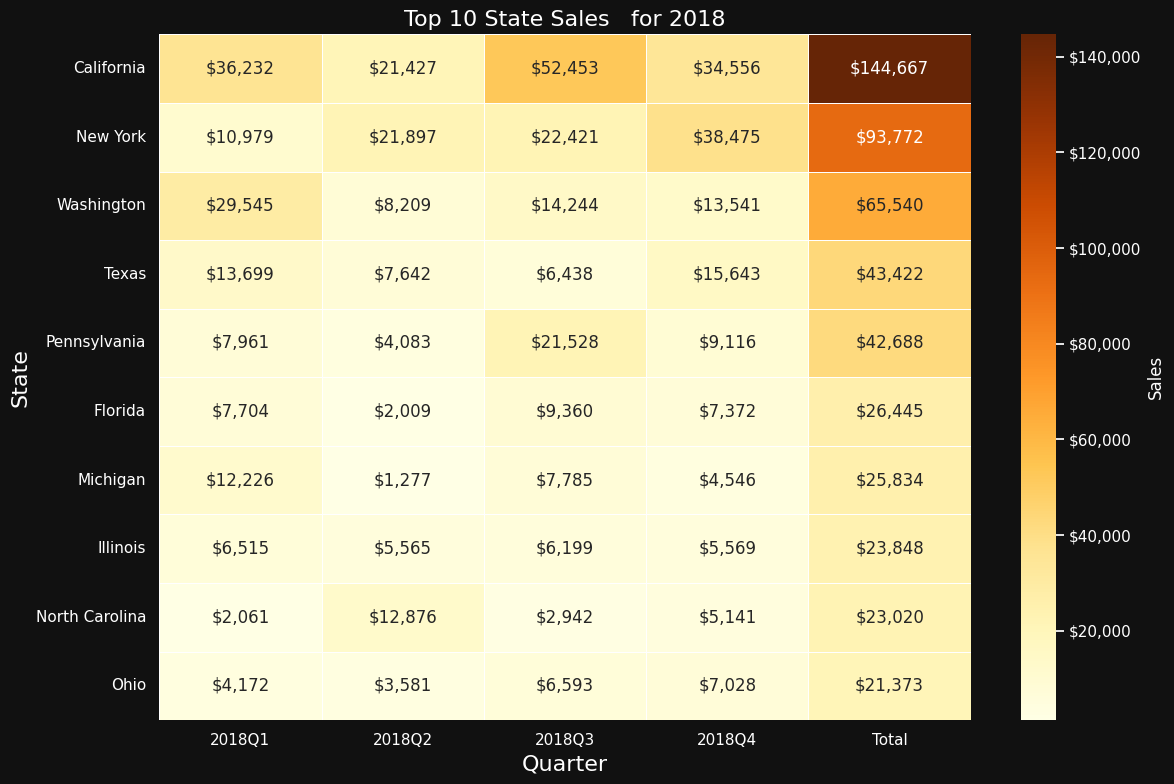

In [2]:
# @title State Sales Strategy for 2018
#-----------------------------------------Logical part start------------------------------------------
# step 1: import required libraries function
import numpy as np
import pandas as pd
from dateutil import parser

# step 2: lode data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vR-6XYWtaoxDCiZOi6PQODs_ubL08CvVzL6Q39LOquPGDTCAMQ3xjTpRLDereRI011A7lbxIS7iXsWU/pub?gid=574248564&single=true&output=csv"
df = pd.read_csv(url)
#df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR-6XYWtaoxDCiZOi6PQODs_ubL08CvVzL6Q39LOquPGDTCAMQ3xjTpRLDereRI011A7lbxIS7iXsWU/pub?gid=574248564&single=true&output=csv')

# step 3: data cleaning
# not a time = NaT
# Solve Date issue
def try_parse_date(x):
  try:
    return parser.parse(x, dayfirst = False)
  except:
    try:
      return parser.parse(x, dayfirst = True)
    except:
      return pd.NaT


df ['Order Date'] = df['Order Date'].apply(try_parse_date)
df = df[df['Order Date'].notna()]
df = df[df['Sales'].notna() &(df['Sales'] > 0)]

# step 4: Filter for 2018 and create Quarter
df_2018 = df[df['Order Date'].dt.year == 2018] #df_2018 er modde sob data ache
df_2018['Quarter'] = df_2018['Order Date'].dt.to_period('Q').astype(str)


# step 4:  Top 10 states by sales (gropuby)
top_10_states = df_2018.groupby('State') ['Sales'].sum().nlargest(10).index.tolist()
top_state = df_2018[df_2018['State'].isin(top_10_states)]


# step 5: feature (table_feature)
table_feature = top_state.pivot_table(
    index ='State',
    columns ='Quarter',
    values ='Sales',
    aggfunc ='sum',

)
table_feature['Total'] = table_feature.sum(axis=1)
table_feature = table_feature.sort_values(by='Total' , ascending = False)


# step 6: Create annotation table for heatmap
annot_table = table_feature.applymap(lambda x: f'${x:,.0f}')

#------------------------------Design part start----------------------------------

# step 1: import required libraries function
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# step 2: theme/style
theme=sns.set_theme(style='darkgrid', rc={
    'axes.facecolor':'#111111',
    'figure.facecolor':'#111111',
    'axes.labelcolor':'white',
    'xtick.color':'white',
    'ytick.color':'white',
    'text.color':'white'
})

# step 3: figure size
plt.figure(figsize=(12,8))

# step 4: heatmap(  colormap , annotaion formating, gridline and linecolor,colorbar cbar  )
colormap=sns.heatmap(table_feature,
            annot=annot_table,
            fmt='',
            cmap ='YlOrBr',
            linewidth=.5,
            linecolor='white',
            cbar_kws = {'label':'Sales',}
            )

# step 5: colorbar access and customizetion
colorbar = colormap.collections[0].colorbar #access
colorbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x:,.0f}')) #customizetion

# step 6: title, xlabel, ylabel
plt.title('Top 10 State Sales   for 2018', color='white', fontsize=16)
plt.xlabel('Quarter', color ='white', fontsize=16)
plt.ylabel('State', color ='white', fontsize=16)

plt.savefig('top 10 state sales 2018.pdf')
plt.savefig('top 10 state sales 2018.png')
# step 7: final layout
plt.tight_layout()
plt.show()

